In [1]:
GIT_ROOT_LINES = !git rev-parse --show-toplevel
WORK_DIR = GIT_ROOT_LINES[0]
%cd $WORK_DIR
%load_ext autoreload
%autoreload 2

/scratch/xz653/code/shape-of-motion


In [10]:
import torch.nn.functional as F
import os.path as osp
import motionblender.lib.pv as pv
from scipy.spatial.transform import Rotation
from glob import glob
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
import torch
import yaml
import pyrender
from copy import deepcopy
from pathlib import Path
import pickle
import numpy as np
from PIL import Image
import random
import pyvista
from motionblender.lib.misc import dump_json, load_cpkl, dump_cpkl, render
import motionblender.lib.convert_utils as cvt_utils
import motionblender.lib.dataset as dataset 
import motionblender.lib.animate as anim
from motionblender.lib.motion import PoseStore
from loguru import logger
import motionblender.lib.mesh2d as mesh_lib
from motionblender.train import iPhoneDatasetVideoView, masked_l1_loss, SSIM
from dataclasses import asdict
import motionblender.lib.mesh2d as mesh2d_utils
from tqdm.auto import tqdm, trange
import motionblender.lib.vis as vis_utils
import torch.nn as nn
torch.set_grad_enabled(False)

def get_splats_at_t(gs_modules, motion_modules, w2c=None, pose_store: PoseStore=None, t: int=-1, with_instance=False):
    if not isinstance(gs_modules, (nn.ModuleDict, dict)):
        gs_modules = {'fg': gs_modules}
        motion_modules = {'fg': motion_modules}
    for m in motion_modules.values(): m.clear_motion_cache()
    
    full_splats = {}
    if w2c is not None:
        cam_center = torch.inverse(w2c)[:, :3, 3]
    else:
        cam_center = None
    for g in gs_modules.keys():
        if g in motion_modules:
            means, quats = gs_modules[g].means, gs_modules[g].get_quats() 
            means, quats = motion_modules[g].transform_splats_to_t(means, t, cano_quats_wxyz=quats, pose_store=pose_store)
        else:
            means, quats = gs_modules[g].means, gs_modules[g].get_quats() 
        full_splats.setdefault('means', []).append(means)
        full_splats.setdefault('quats', []).append(quats)
        full_splats.setdefault("scales", []).append(gs_modules[g].get_scales())
        full_splats.setdefault("opacities", []).append(gs_modules[g].get_opacities())

        if cam_center is not None:
            cam_center = cam_center.to(means.device)
        colors = gs_modules[g].get_colors(means, cam_center)
        if with_instance:
            if g in motion_modules:
                colors = torch.cat([colors, torch.ones_like(colors[..., :1])], dim=-1)
            else:
                colors = torch.cat([colors, torch.zeros_like(colors[..., :1])], dim=-1)
        full_splats.setdefault("colors", []).append(colors)

    full_splats = {k:torch.cat(v) for k, v in full_splats.items()}
    return full_splats


BG_COLOR = [82, 87, 110] # paraview background color, looks good

def find_white_background_mask(img: Image, threshold: int = 245) -> Image:
    """
    Identify near-white background pixels in a PIL image.

    Args:
        img:        A PIL Image (any mode).
        threshold:  Int in [0,255].  A pixel is considered 'white' if
                    R >= threshold AND G >= threshold AND B >= threshold.

    Returns:
        A PIL Image in mode 'L' (grayscale) where white areas (255)
        correspond to background, and black (0) to foreground.
    """
    # 1) ensure 3-channel RGB
    rgb = img.convert('RGB')
    # 2) to NumPy array H×W×3
    arr = np.array(rgb)
    # 3) mask = all channels ≥ threshold
    white_mask = np.all(arr >= threshold, axis=2)
    # 4) convert boolean mask → uint8 0/255, back to PIL
    mask_img = Image.fromarray((white_mask.astype('uint8') * 255), mode='L')
    return mask_img


def remove_bg(img, threshold=200):
    mask_img = find_white_background_mask(img, threshold=threshold)
    mask_inds = np.array(mask_img)[..., None] < 1
    new_img = np.array(img) * mask_inds 

    new_img[~mask_inds.squeeze()] = np.array(BG_COLOR) # (np.array([0.7, ] * 3) * 255).astype(int)
    return Image.fromarray(new_img)

show = vis_utils.to_pil

In [13]:
from motionblender.app.main import MeshRenderBackend
IMG_WH = [640, 480]
mesh_renderer = MeshRenderBackend()
mesh_renderer.pyrender = pyrender.OffscreenRenderer(viewport_width=IMG_WH[0], viewport_height=IMG_WH[1])

Translator(prefix=None)
awaiting runner setup
awaiting site startup
Print WSLINK_READY_MSG
Schedule auto shutdown with timout 0
awaiting running future
trigger(trigger__1)
trigger(trigger__2)
trigger(P_0x2ad10b793fa0_0Camera)
trigger(P_0x2ad10b793fa0_0AnimateStart)
trigger(P_0x2ad10b793fa0_0AnimateStop)
js_key = class
js_key = style
js_key = fluid
js_key = class
before: class = { 'rounded-circle': !P_0x2ad10b793fa0_0_show_ui }
(prefix=None) token {
has({ => {) = False
(prefix=None) token  
has(  =>  ) = False
(prefix=None) token '
has(' => ') = False
(prefix=None) token rounded
has(rounded => rounded) = False
(prefix=None) token -
has(- => -) = False
(prefix=None) token circle
has(circle => circle) = False
(prefix=None) token '
has(' => ') = False
(prefix=None) token :
has(: => :) = False
(prefix=None) token  
has(  =>  ) = False
(prefix=None) token !
has(! => !) = False
(prefix=None) token P_0x2ad10b793fa0_0_show_ui
has(P_0x2ad10b793fa0_0_show_ui => P_0x2ad10b793fa0_0_show_ui) = True


2025-05-10 20:34:49.261 | INFO     | motionblender.lib.pv:url:498 - pyvista viewer url: http://localhost:45121/index.html?ui=P_0x2ad10b793fa0_0&reconnect=auto


In [11]:
def vis_graph(rendered_img, all_joints, w2c, K, return_graph=False, joints_color=None, link_colors=None):
    joints_color = joints_color or ['red'] * len(all_joints)
    link_colors = link_colors or ['blue'] * len(motion.links)
    link_rad = {'microwave':0.03, 'cloth':0.01, 'rope': 0.015}[SCENE]
    mesh_renderer.update_scene(all_joints, motion.links,
        joints_color,
        link_colors,
        K,
        intensity=3.0,
        link_radius=link_rad
    )
    mesh_renderer.update_camera(w2c.clone())
    graph_color, graph_depth, graph_mask = mesh_renderer.render()

    link_opacity = {'microwave':0.7, 'cloth':0.7, 'rope': 0.5}[SCENE]
    graph_mask_ = torch.from_numpy(graph_mask[..., None].copy()).float()
    rendered_img = rendered_img.cpu()

    graph_rgb_img = rendered_img * (1 - graph_mask_) + graph_mask_ * ((torch.from_numpy(graph_color.copy()).float() / 255) * link_opacity + rendered_img * (1 - link_opacity))
    if not return_graph:
        return show(graph_rgb_img)
    else:
        return show(graph_rgb_img), {'graph_color': graph_color, 'graph_mask': graph_mask}

In [4]:
SCENE = 'cloth'
data_cfg = dataset.MotionBlenderGeneralDataConfig(data_dir=f'./datasets/robot/{SCENE}', 
                                                split='train', use_tracks=False, normalize_scene=False, use_median_filter=True)
D_center = iPhoneDatasetVideoView(dataset.MotionBlenderGeneralDataset(**asdict(data_cfg), img_prefix='center'))

2025-05-10 20:16:47.985 | WARNING  | motionblender.lib.dataset:__init__:394 - use_tracks is False, but given_cano_t is not set


Loading train images:   0%|          | 0/615 [00:00<?, ?it/s]

2025-05-10 20:17:36.362 | WARNING  | motionblender.lib.dataset:__init__:530 - preinited motion graph found, cano_t = 0


Loading train depths:   0%|          | 0/615 [00:00<?, ?it/s]

max_depth_value tensor(30.7450)


Processing depths:   0%|          | 0/615 [00:00<?, ?it/s]

2025-05-10 20:18:17.292 | WARNING  | motionblender.lib.dataset:__init__:718 - no scene normalization is applied for datasets/robot/cloth!


In [5]:
gses, motions, _, names = load_cpkl('./outputs/weights/robot/cloth/ckpt.cpkl')
INST_NAME = names[-1]
print(INST_NAME)
gs, motion = gses[INST_NAME], motions[INST_NAME]

cloth-1


In [6]:
cloth_mesh_grid_indexes = {'top_left': 4, 'top_right': 7, 'bottom_right': 6, 'bottom_left': 5} 
# special joints on the cloth mesh, this dict is returned by the motionblender.lib.mesh2d.generate_parallelogram_mesh_3d

In [7]:
pose_store = load_cpkl('./outputs/weights/robot/cloth/pose_store.pkl')

In [9]:
sample = D_center[0]
w2c, K = sample['w2cs'].cuda(), sample['Ks'].cuda()

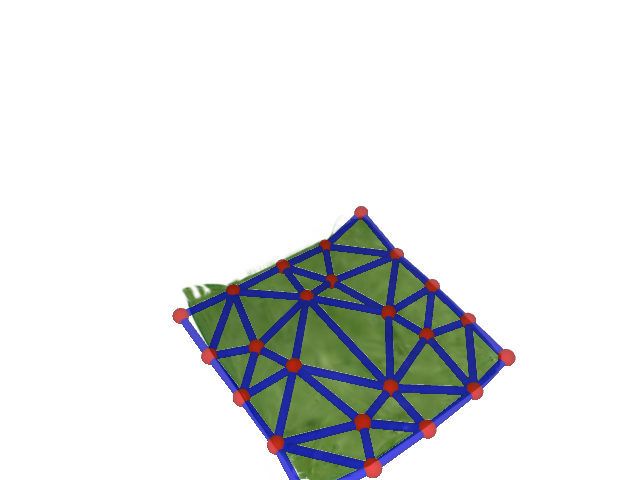

In [14]:
splat_dict = get_splats_at_t(gs, motion, pose_store=pose_store)
rendered_img = render(splat_dict, w2c, K, IMG_WH, depth=False)[0]
all_joints = motion._joints_tensor_cache[-1].clone()
vis_graph(rendered_img, motion._joints_tensor_cache[-1], w2c, K)

In [23]:
def rotate_points_around_axis(A: np.ndarray,
                              B: np.ndarray,
                              S: np.ndarray,
                              deg: float) -> np.ndarray:
    """
    Rotate points S around the axis defined by A→B by deg degrees.

    Parameters
    ----------
    A : np.ndarray, shape (3,)
        First endpoint of the rotation axis.
    B : np.ndarray, shape (3,)
        Second endpoint of the rotation axis.
    S : np.ndarray, shape (N,3)
        Points to rotate.
    deg : float
        Rotation angle in degrees. Positive follows the right‐hand rule
        around the axis from A towards B.

    Returns
    -------
    S_rot : np.ndarray, shape (N,3)
        The rotated points.
    """
    # ensure inputs are arrays
    A = np.asarray(A, dtype=float).reshape(3)
    B = np.asarray(B, dtype=float).reshape(3)
    S = np.asarray(S, dtype=float)
    if S.ndim != 2 or S.shape[1] != 3:
        raise ValueError("S must be of shape (N,3)")

    # build unit axis vector u
    axis = B - A
    norm = np.linalg.norm(axis)
    if norm == 0:
        raise ValueError("A and B must be distinct points to define a rotation axis.")
    u = axis / norm

    # convert angle to radians and precompute sin/cos
    theta = np.deg2rad(deg)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    # translate points so A is the origin
    P = S - A  # shape (N,3)

    # Rodrigues' rotation:
    #   P_rot = P*cosθ + (u×P)*sinθ + u*(u·P)*(1−cosθ)
    # Compute u·P for each point: shape (N,)
    u_dot_P = P @ u  # dot along axis

    # Compute cross product u × P: shape (N,3)
    u_cross_P = np.cross(u, P)

    # Combine terms
    term1 = P * cos_t
    term2 = u_cross_P * sin_t
    term3 = (u * u_dot_P[:, None]) * (1 - cos_t)

    P_rot = term1 + term2 + term3

    # translate back
    S_rot = P_rot + A
    return S_rot


def clamp_points_to_side_with_margin(A: np.ndarray,
                                     B: np.ndarray,
                                     E: np.ndarray,
                                     D: np.ndarray,
                                     margin: float) -> np.ndarray:
    """
    Clamp points D so that, in the XY‐plane,
      1) they lie on the same side of the infinite line AB as point E, and
      2) their perpendicular distance to that line is at least `margin`.

    Any point violating (1) or (2) is snapped to the line‐projection plus
    an offset of exactly `margin` along the correct normal direction.
    Z‐coordinates remain unchanged.

    Parameters
    ----------
    A, B : np.ndarray, shape (3,)
        Endpoints defining the line AB.
    E : np.ndarray, shape (3,)
        A “side‐selector” point: defines which side is the “inside.”
    D : np.ndarray, shape (N,3)
        Points to clamp.
    margin : float
        Minimum required perpendicular distance from AB (in XY).

    Returns
    -------
    D_clamped : np.ndarray, shape (N,3)
        The adjusted points.
    """
    # flatten & split XY/Z
    A = A.reshape(3);  B = B.reshape(3);  E = E.reshape(3)
    D = D.reshape(-1, 3)
    A_xy, B_xy, E_xy = A[:2], B[:2], E[:2]
    D_xy = D[:, :2]

    # direction & length of AB in XY
    d = B_xy - A_xy
    L2 = d.dot(d)
    if L2 == 0:
        raise ValueError("A and B must differ in XY.")
    L = np.sqrt(L2)

    # unit normal (points to +90° from d), then orient to E‐side
    n_unit = np.array([-d[1], d[0]]) / L
    side_E = np.sign(d[0]*(E_xy[1]-A_xy[1]) - d[1]*(E_xy[0]-A_xy[0]))
    if side_E == 0:
        raise ValueError("E must not lie exactly on the line AB.")
    n_E = n_unit * side_E  # outward normal toward E‐side

    # compute for each D: projection‐parameter t, projection P, signed distance s
    v = D_xy - A_xy  # (N,2)
    t = (v @ d) / L2  # (N,)
    P = A_xy + np.outer(t, d)  # (N,2)
    signed_dist = v @ n_unit  # (N,) = positive if same side as +n_unit

    # mask points that need moving: signed_dist*side_E < margin
    mask = (signed_dist * side_E) < margin

    # for those, place at P + margin * n_E
    D_xy_new = D_xy.copy()
    D_xy_new[mask] = P[mask] + margin * n_E

    # assemble final array
    D_clamped = D.copy()
    D_clamped[:, :2] = D_xy_new
    return D_clamped


def simulate_cloth_folding(all_joints, pose_store, start_name, deg):
    if abs(deg) < 90:
        num_points1 = 6 
        num_points2 = 0
        clamp_joints = False
    else:
        num_points1 = 6
        num_points2 = 12
        clamp_joints = True
    
    _1, _2 = start_name.split('_')
    end_name = {'top': 'bottom', 'bottom': 'top'}[_1] + '_' + {'left': 'right', 'right': 'left'}[_2]
    axis_name1, axis_name2 = list(set(cloth_mesh_grid_indexes.keys()) - {start_name, end_name})
    start_ind, end_ind, axis_ind1, axis_ind2 = [cloth_mesh_grid_indexes[n] for n in [start_name, end_name, axis_name1, axis_name2]]

    start_point = all_joints[start_ind]
    axis_point1, axis_point2 = all_joints[axis_ind1], all_joints[axis_ind2]

    norms = (all_joints - start_point[None]).norm(dim=1)
    
    indices1 = norms.topk(num_points1, largest=False).indices
    indices2 = norms.topk(num_points2, largest=False).indices

    indices2 = [i  for i in indices2.tolist() if i not in set(indices1.tolist())]
    indices2 = torch.as_tensor(list(indices2)).to(all_joints.device)

    # set1
    ready_axis_point1, ready_axis_point2 = axis_point1.cpu().numpy(), axis_point2.cpu().numpy()
    rotated_points1 = rotate_points_around_axis(ready_axis_point1, ready_axis_point2, all_joints[indices1].cpu().numpy(), deg=deg)

    # set2
    if len(indices2) > 0:
        rotated_points2 = rotate_points_around_axis(axis_point1.cpu().numpy(), axis_point2.cpu().numpy(), all_joints[indices2].cpu().numpy(), deg=deg)
        rotated_points = np.concatenate([rotated_points1, rotated_points2])
    else:
        rotated_points = rotated_points1
    moving_inds = torch.cat([indices1, indices2]).long()

    action_joint_inds = moving_inds.tolist() 
    action_link_inds = []
    for i in range(len(motion.links)):
        link = motion.links[i]
        if int(link[0]) in action_joint_inds or int(link[1]) in action_joint_inds:
            action_link_inds.append(i)
    
    if clamp_joints:
        rotated_points = clamp_points_to_side_with_margin(axis_point1.cpu().numpy(), axis_point2.cpu().numpy(), all_joints[end_ind].cpu().numpy(), rotated_points, 
                            0.02)

    _joints = all_joints.clone() 
    _joints[moving_inds] = torch.as_tensor(rotated_points).float().to(_joints.device)

    _pose_store = deepcopy(pose_store)
    _pose_store.joints = anim.apply_mat4(torch.inverse(pose_store.global_T), _joints)

    splat_dict = get_splats_at_t(gs, motion, pose_store=_pose_store)

    result = {}
    for cam_name, _w2c, _K in [['center', w2c, K]]:
        rendered_img = render(splat_dict, _w2c, _K, IMG_WH, depth=True, bg_color=torch.as_tensor(BG_COLOR).cuda().float() / 255.)[0]
        rendered_img = rendered_img[..., :3]
        rendered_depth = rendered_img[..., -1]

        graph_pil, graph_dict = vis_graph(rendered_img, _joints, _w2c, _K, return_graph=True)
        rgb_pil = show(rendered_img)
        result[cam_name] = {'rgb': rgb_pil, 
                            'graph': graph_pil, 
                            'graph_only': show(graph_dict['graph_color']),
                            'depth': rendered_depth}
    return result

In [25]:
result = simulate_cloth_folding(all_joints, pose_store, 'top_right', -120)

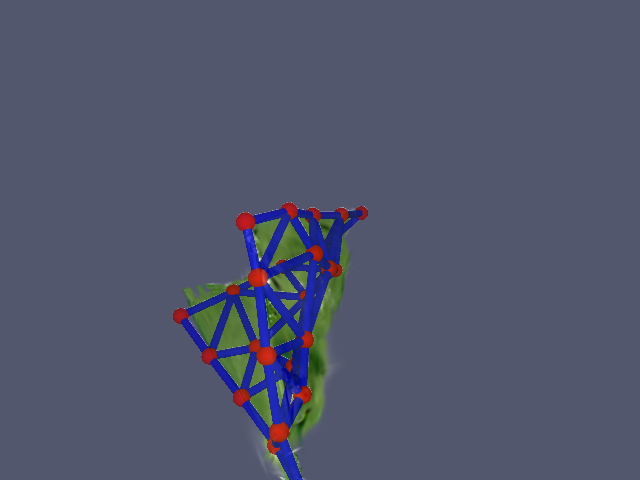

In [26]:
result['center']['graph']

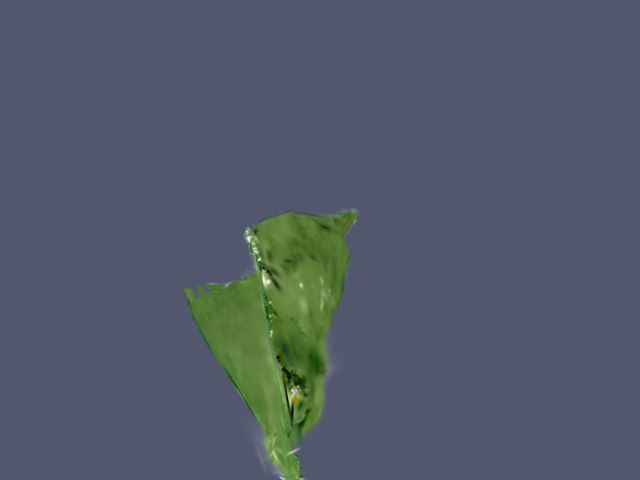

In [27]:
result['center']['rgb']